#3 - Serial information processing
This notebook is part of the supplementary material for:  
Genewein T., Leibfried F., Grau-Moya J., Braun D.A. (2015) *Bounded rationality, abstraction and hierarchical decision-making: an information-theoretic optimality principle*, Frontiers in Robotics and AI.  

See the original publication at **link** (**DOI**)

More information on how to run the notebook on the accompanying github repsitory **link** where you can also find updated versions of the code and notebooks.

This notebook corresponds to Section 3 and reproduces Figures 5, 6, 7 and 8 of the paper.

## Two-stage serial information processing
Here, we design a two-stage serial information processing system that first processes a world-state $w$ into an internal percept $x$ and then uses this percept to compute an action $a$. We assume that the action is conditionally independent of the world-state given the percept. This simply means that there is no direct flow of information from $W$ to $A$ and corresponds to the following graphical model
$$ W \rightarrow X \rightarrow A$$
that leads to $p(w,x,a)=p(w)p(x|w)p(a|x)$.

Each stage of the information processing system is characterized by an information-theoretic channel 
 * $W \rightarrow X$ with the rate $I(W;X)$
 * $X \rightarrow A$ with the rate $I(X;A)$
 
We want to maximize the utility function $U(w,a)$ while at the same time not exceeding some limits on the information processing rates on each stage. This can be formalized with the following variational problem
$$\underset{p(x|w),p(a|x)}{\operatorname{arg~max}}~\mathbf{E}_{p(w,x,a)}[U(w,a)] - \frac{1}{\beta_1} I(W;X) - \frac{1}{\beta_2} I(O;A)$$

The solution to the optimization problem is given by
$$\begin{align}
p^*(x|w)&=\frac{1}{Z(w)}p(x)\exp\left(\beta_1 \Delta F_{\text{ser}}(w,x)\right)\\
p(x)&=\sum_w p(w)p^*(x|w)\\
p^*(a|x)&=\frac{1}{Z(x)} p(a) \exp \left(\beta_2 \sum_w p(w|x) U(w,a) \right)\\
p(a)&=\sum_{w,x} p(w)p^*(x|w)p^*(a|x),
\end{align}$$
where $Z(w)$ and $Z(x)$ denote the corresponding normalization constants or partition sums. The conditional probability $p(w|x)$ is given by Bayes' rule $p(w|x) = \frac{p(w)p^*(x|w)}{p(x)}$ and 
$$\Delta F_{\text{ser}}(w,x):=\mathbf{E}_{p^*(a|x)}[U(w,a)] -  \frac{1}{\beta_2} D_{\mathrm{KL}}(p^*(a|x)||p(a))$$
is the free energy difference of the action stage.

## Perception-action systems
Interestingly, the solutions above can be used for constructing bounded-optimal perception-action systems. Perception-action systems need to perform inference over a (hidden) world-state $w$ and then use the gathered information $x$ to drive a decision-maker. Classically, inference and decision-making are separated:
$$\begin{align}
&\text{Bayesian inference:} & p(w|x)&=\frac{p(w)p(x|w)}{\sum_w p(w)p(x|w)} \\
&\text{Bounded rational decision:} & p^*(a|x)&=\frac{1}{Z(x)}p(a)e^{\beta_2 U(x,a)} 
\end{align}$$
where the last equation describes a bounded rational decision-maker as in Section 2 of the paper. The problem is that in such a case there is no principled way to specify the likelihood model $p(x|w)$. Often it is chosen to represent the world-state as faithfully as possible. 

Now compare the two equations for Bayesian inference and bounded rational decision making with the four equations that we got as the solution to our variational problem. Interestingly Bayesian inference and bounded rational decision making drop out naturally - additionally the bounded optimal likelihood model $p^*(x|w)$ is also well-defined. Interestingly it does not try to represent $w$ as faithfully as possible but rather it tries to optimize the downstream free-energy trade-off of the action-part of the system. This leads to a tight coupling between action and perception, which will be illustrated in the example below.

## Comparison against hand-crafted perception $p_\lambda(x|w)$
Below, we compare the bounded-optimal perception-action system against a system that uses a handcrafted likelihood $p_\lambda(x|w)$. The model has a tunable precision-parameter $\lambda$ that affects the information processing rate of the perceptual channel $I(X;W)$ - this parameter corresponds to the level of perceptual noise and influences the likelihood of "confusing" one particular $w$ with similar ones.

The observation or percept $x$ is a discretized noisy version of $w$ with precision $\lambda$:

$$x|w,\lambda \sim \text{round}(\mathcal{N}(w,1/\lambda))$$

By using this construction it is already obvious that the action-part of the system or the utility function have no influence on the perceptual part of the system. We will highlight this further in the example below.

In [1]:
using RateDistortionDecisionMaking, Distances, DataFrames, Colors, Gadfly, Distributions, Interact, Reactive

#make the default plot size a bit larger
set_default_plot_size(15cm, 12cm)

## Utility U(a,w)

To illustrate perception-action systems we design the follwing example. The agent is an animal and it encounters nine other kinds of animals that come in three different size-groups - each group has three members.
*  G1: Small: 2,3,4
*  G2: Medium: 6,7,8
*  G3: Large: 10,11,12

The agent has sensors to observe $x$ which is a noisy version of $w$. The rate $I(W;X)$ governs how precise or noisy the percept is (for the hand-crafted model the precision is directly controlled by $\lambda$). Medium precision mostly leads to within-group confusion, low precision $\lambda$ leads to strong across-group confusion. 

The agent can hunt the animals of the small and medium-sized group for food but it must flee from the large animals as it could fall prey to them. Alternatively, you can change the utility function to a mating scenario, where the agent must try to find a animals of a specific size within the medium-sized group to mate with (see description below the plot of the utility function for more details).

###[Interact] Change the utility function and see how the percept is affected  
... change the utility function by commenting/uncommenting in the code-block below. If all other parameters are kept the same, we can observe how the bounded optimal percept $p^*(x|w)$ is coupled to the utility function.

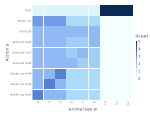

In [2]:
#set up predator-prey example
include("PredatorPreyExample.jl")

###### Predator-prey scenario #############
#same utility as used in the main paper
w_values, w_strings, a_values, a_strings, p_w, U = setup_predator_prey_example()

###### Mating scenario ####################
#alternative utility - mating scenario
#w_values, w_strings, a_values, a_strings, p_w, U = setup_predator_prey_example(mating_utility=true)


numa = length(a_strings)
a_vec = [1:numa]

numw = length(w_strings)
w_vec = [1:numw]

#pre-compute utility
U_pre, Umax = setuputilityarrays(a_values,w_values,U)

#visualize utility

plt_utility = visualizeMatrix(U_pre, w_values, a_values, w_strings, a_strings, xlabel="animal size w",
                              ylabel="Action a", legendlabel="U(a,w)")

## Predator-prey scenario
Possible kinds of **animals**:
*  Small animals (w={2,3,4})
  * Can't hear well - sneaking up on them is very likely succesful
  *  The generic sneak-up pattern works very well
  *  An ambush also works but bears the risk that the animal is not moving towards you
  * For each w2, w3, w4 there is a specific sneak-up pattern that increases chances of success for that particular kind of animal - however, using it on the wrong animal, the success rate will be 20% lower  
*  Medium-sized animals (w={6,7,8})
  *  Can hear well - sneaking up on them has lower chances of success compared to ambush
  *  The generic ambush pattern works well but bears the risk that the animal is not moving towards you
  *  A sneak up might also work but chances are quite low
  *  There are specific ambush patterns for w6, w7, w8 but using them has no advantage over the generic ambush, however using them on the wrong animal, the sucess rate will be 20% lower 
*  Large animals (w={10,11,12})
  *  Can potentially kill you, your chances of survival are low if you sneak up or ambush them (no matter with which kind of pattern)
  *  If you flee, your chances of survival are quite good
  
  
Possible kinds of **actions**:
*  Generic *Ambush*: wait for the animal to get close and then strike
  *  advantage: causes no noise
  *  disadvantage: animal might not come towards you
*  Generic *Sneak up*: slowly move closer to the animal and then strike
  *  advantage: works also if animal is not moving towards you
  *  disadvantage: animal might hear or you and flee
*  Generic *Flee*: run away from animal
  *  advantage: if animal could kill you, your chances of survival are significantly increased
  *  disadvantage: if animal was potential prey you missed out on food
*  Specific *Sneak up* for w={2,3,4}: specific sneak up pattern that increases success when applied to exactly the right kind of animal, but decreases success when applied to another animal within the small animal group. When applied to an animal from the medium-sized animal group, the success-rate is equal to the generic sneak up pattern.
*  Specific *Ambush* for w={6,7,8}: does not increase success compared to generic ambush pattern, but decreases success when applied to another animal within the medium-sized group. When applied to an animal from the small group, the success-rate is equal to the generic ambush pattern. As there is no advantage of the specific pattern over the genric pattern (but it might be disadvantegous when applied to the wrong animal), any bounded-rational decision-maker should assign no probability mass to these specific ambush patterns since using them would not increase the expected utility but would increase the informational cost.


  
  
Compared to the generic sneak-up and ambush patterns, the specific patterns require more computational resources, that is they require a larger rate on the action-channel, or in other words: they require good motor skills and a good motor hardware (which is more costly than a cheap motor system).

If you have bad motoric hardware, you'll never be able to use the specific hunting patterns, therefore it doesn't make sense to waste resources on an expensive perceptual system that allows you to precisely distinguish individual animals. Rather a system that allows you to tell the different groups from each other suffices. Dually, if your perceptual system does not allow you to distinguish between the individual animals, it would be lavish to have an expensive motor system that allows you to accurately execute very specific hunting patterns.


##Mating scenario
You are a medium sized animal (w=6) and try to find a mate - potential mates are w=8.

Possible actions
*  Display
  * Get the attention of the other animal which could be a potential mate
*  Flee
  * Quickly flee from the other animal

Possible kinds of **animals**:
*  Small animals (w={2,3,4})
  * Uninteresting. Fleeing from them will cost resources, displaying to them will also waste a similar amount of resources. 
*  Medium-sized animals
  *  w=6 rival, same size as you: displaying to them might drive them away, but has a risk of confrontation. Fleeing significantly decreases your chances of mating.
  *  w=7 rival, bigger than you. Displaying to them will most probably get you injured, fleeing from them is the better option.
  *  w=8 potential mate. Displaying to them will significantly increase your chances to mate, fleeing from them has a low utility.
*  Large animals (w={10,11,12})
  *  Can potentially kill you, fleeing from them is good, displaying to them will almost surely get you killed.
  
  
  
**TODO: describe mating utility**

## Hand-crafted perceptual model $p_\lambda(x|w)$

Below, the hand-crafted perceptual model can be inspected by changing the precision parameter $\lambda$. Note that this will also directly influence the rate $I(W;X)$.

Slider{Float64}([Input{Float64}] 2.5,"Perceptual precision λ",2.5,0.1:0.1:5.0)

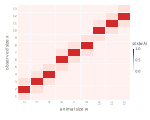

In [3]:
#set up hand-crafted likelihood model and p(x|w)
x_values = [1:13]
x_vec = [1:length(x_values)]
x_strings = map((x)->string(x), x_values)


#slider for selecting λ
λ_vals = 0.1:0.1:5
slider_l = slider(λ_vals,label="Perceptual precision λ")


#use lift to connect the actual plotting-code to the dropdown box
plt_pxgw_sl = lift(λ_vis->begin
                            p_xgw_hc = pogw_handcrafted(x_values, w_values, λ_vis)
                            visualizeBAconditional(p_xgw_hc, x_vec, w_vec, x_strings, w_strings,
                                                   wlabel="animal size w", alabel="observed size x", legendlabel="p(x|w,λ)")
                                                   end, slider_l)

display(slider_l)
display(plt_pxgw_sl)

###[Interact] See how the precision $\lambda$ governs perceptual noise
...drag the slider above to change the perceptual precision and see how observations get more and more "blurry" with decreasing precision. Note that low perceptual precision incurs a low mutual information $I(X;W)$ whereas high precision also incurs a large mutual information between the actual size and the observed size.

# Compare bounded-optimal and hand-crafted models

## [Interact] Set parameters to compare the two cases here:
When changing the parameters make sure to re-run the corresponding cells below - in case of doubt simply re-run all cells below.

### Cases that work nicely:

*  $\lambda=1.65$, $\beta_1 = 8$, $\beta_2 = 10$ (same $I(X;W)$ for both models - almost unbounded actor)
*  $\lambda=1.65$, $\beta_1 = 8$, $\beta_2 = 1$ (same EU - bounded actor, optimal perception changes, given the limits on the action channel)
*  $\lambda=0.4$, $\beta_1 = 1$, $\beta_2 = 10$ (same $I(X;W)$ for both models - bounded actor, optimal action changes, given the limits on the perceptual channel)



*  $\lambda=10$, $\beta_1 = 10$, $\beta_2 = 5$, mating-utility (optimal perception changes under a different utility function - compare against case above with identical parameters but different utility function)

### Things to try:

Change the temperature on the action-channel (with very large resources on the observation channel) and see how the perception is affected by the action.

Change the temperature on the perception-channel (with very large resources on the action channel) and see how the action is affected by perception.

Change the utility function (mating-utility) and see how the percept is affected by the new utility.

In [4]:
#precision of the hand-crafted perceptual model
λ = 1.65 #0.4 #1.65
#the "price" for I(X;W) in the handcrafted case will be β1 (as given below)
#to make the two cases comparable. If you want I(X;W) to be the same in both
#cases, set β1 and run the sequential case and then tune λ until the mutual
#information terms are equal.
#
#Note that β2 will also be used for the bounded rational decision-maker that
#uses the hand-crafted perception. This should allow for easy comparison of
#the action-channels in both cases (hand-crafted vs. sequential case)

#inverse temperatures for sequential case
#β1: perceptual channel -> price for I(X;W)
#β2: action channel -> price for I(A;X)
#β3=0 sequential case (otherwise the general three-variable case is specified)
β1 = 8 #1
β2 = 10
β3 = 0;

## Bounded rational decision maker based on hand-crafted perception

The code cells below simulate a bounded-rational decision-maker using the hand-crafted perceptual model and visualize the solution.

In [5]:
#compute hand-crafted perception, then feed it into bounded rational decision-maker
#with inv. temperature β2 and compute optimal p(a|x) using hand-crafted p(x|w)
p_xgw_hc = pogw_handcrafted(x_values, w_values, λ)


numx = length(x_vec)
numa = length(a_vec)

#comptue expected utility under posterior over w given x
#
#posterior p(w|x)
p_wgx = zeros(numw, numx)
for k in 1:numx
    p_wgx[:,k] = p_xgw_hc[k,:]' .* p_w
    p_wgx[:,k] += eps()  #add small epsilon to prevent numerical problems for λ>>
    p_wgx[:,k] /= sum(p_wgx[:,k])
end

#U(a,x)=∑_w p(w|x)U(a,w)
U_ax = zeros(numa, numx)
for k in 1:numx
    U_ax[:,k] = U_pre * p_wgx[:,k]
end


#p(x)=∑_w p(w)p(x|w)
p_x_hc = p_xgw_hc * p_w
#make sure that p(x) has non-zero entries (otherwise numerical problems arise in I(X;W))
p_x_hc += eps()
p_x_hc /= sum(p_x_hc)


#solve the decision-making part with one-step Blahut-Arimoto
ε = 0.0001 #convergence critetion for BAiterations
maxiter = 5000 #maximum number of BA iterations

#initialize p(a) uniformly
num_acts = length(a_vec)
pa_init = rand(num_acts)
pa_init /= sum(pa_init)

#BA iterations
p_agx_hc, p_a_hc, perf_df_hc = BAiterations(pa_init, β2, U_ax, p_x_hc, ε, maxiter,
                                            compute_performance=true, performance_as_dataframe=true)

; #suppress output

In [6]:
#visualize solution p(x|w), p(a|x), p(a|w)

#p(x|w)
plt_pxgw_hc = visualizeBAconditional(p_xgw_hc, x_vec, w_vec, x_strings, w_strings,
                                     wlabel="animal size w", alabel="observed size x", legendlabel="p(x|w,λ)")

#p(a|x)
plt_pa_hc, plt_pagx_hc = visualizeBAsolution(p_a_hc, p_agx_hc, a_vec, x_vec, a_strings, x_strings,
                                             wlabel="observed size x", alabel="action a",
                                             legendlabel_marginal="p(a)", legendlabel_conditional="p(a|x,λ)",
                                             suppress_vis=true)

#compute p(a|w)
#p(a|w) = ∑_x p(x|w)p(a|x)
p_agw_hc =  p_agx_hc * p_xgw_hc
plt_pagw_hc = visualizeBAconditional(p_agw_hc, a_vec, w_vec, a_strings, w_strings,
                                     wlabel="animal size w", alabel="action a", legendlabel="p(a|w,λ)")


#visualize p(x|w)
display(plt_pxgw_hc)
#visualize p(a|x)
display(plt_pagx_hc)
#visualize p(a|w)
display(plt_pagw_hc)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 animal size w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 0.5 
 1.0 
 0.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(x|w,λ) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 observed size x

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 observed size x 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 
 0.5 
 1.0 
 0.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(a|x,λ) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 action a

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 animal size w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 0.5 
 1.0 
 0.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(a|w,λ) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 action a

The plots above show $p_\lambda(x|w)$, $p_\lambda(a|x)$ and the overall behavior $p_\lambda(a|w)$ respectively. 

Below we compute the information terms of the hand-crafted solution and visualize them.

**! Note that in the legends below $O$ is used instead of $X$**

In [7]:
#compute p(a|x,w) = p(a|x) ∀w
p_agxw_hc = zeros(numa, numx, numw)
for j in 1:numw
    p_agxw_hc[:,:,j] = p_agx_hc
end

#compute performance measures of solution
res_hc = analyze_three_var_BAsolution(p_w, p_x_hc, p_a_hc, p_xgw_hc, p_agx_hc, p_agxw_hc, p_agw_hc, U_pre, β1, β2, β3)
perf_df_hc = performancemeasures2DataFrame(res_hc...)
    
#visualize
p_MI, p_composed, p_perf = plot_three_var_performancemeasures(perf_df_hc, maximum(U_pre), β1, β2, β3)

display(hstack(p_MI, p_composed))
display(p_perf)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 H(O) 
 H(A) 
 H(A|O) 
 H(A) 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 H(O|W) 
 H(A|O) 
 H(A|O,W) 
 H(A|W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 -5 
 0 
 5 
 10 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 
 
 [bits] 
 
 
 Composition of entropic terms 
 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 4.1 
 4.2 
 4.3 
 4.4 
 4.5 
 4.6 
 4.7 
 4.8 
 4.9 
 5.0 
 -2.5 
 0.0 
 2.5 
 5.0 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 
 
 [bits] 
 
 
 Mutual information terms

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 E[U] 
 E[U] 
 
 
 
 E[U] 
 1/β1 I(O;W) 
 1/β2 I(A;O) 
 1/β3 I(A;W|O) 
 J = E[U] - 1/β ∑ I 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 -5.0 
 -4.8 
 -4.6 
 -4.4 
 -4.2 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 8.2 
 8.4 
 8.6 
 8.8 
 9.0 
 9.2 
 9.4 
 9.6 
 9.8 
 10.0 
 -5 
 0 
 5 
 10 
 -5.0 
 -4.5 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 8.5 
 9.0 
 9.5 
 10.0 
 
 
 [utils] 
 
 
 Utility vs. processing-cost trade-off

## Two-step sequential bounded rational decision maker (perception + action)

The code below simulates and visualizes a bounded optimal perception action system.

In [8]:
ε = 0.0001 #convergence critetion for BAiterations
maxiter = 5000 #maximum number of BA iterations



#This function performs Blahut-Arimoto iterations for the three-variable general case
px, pa, pxgw, pagx, pagxw, pagw, performance_df = threevarBAiterations(numx, β1, β2, β3, U_pre, p_w, ε, maxiter,
                                                  compute_performance=true, performance_as_dataframe=true,
                                                  init_pogw_sparse = true, init_pogw_uniformly = false,
                                                  init_pagow_uniformly = true);

In [9]:
#call the routine that creates plots for all the probability distributions
plt_px, plt_pa, plt_pxgw, plt_pagx, plt_pagw, dpdown, plt_pagow_vis = visualize_three_var_BAsolution(px, pa,
                                                                      pxgw, pagx, pagxw, pagw,
                                                                      x_vec, a_vec, w_vec,
                                                                      x_strings, a_strings, w_strings, 
                                                                      olabel_string="x", alabel_string="a", wlabel_string="w")

#visualize p(x|w)
display(plt_pxgw)
#visualize p(a|x)
display(plt_pagx)
#visualize p(a|w)
display(plt_pagw)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 World state w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 0.5 
 1.0 
 0.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(x|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 Observation x

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Observation x 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 
 0.5 
 1.0 
 0.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a|x) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 Action a

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 World state w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 0.5 
 1.0 
 0.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 Action a

The plots above show the bounded optimal solutions $p^*(x|w)$, $p^*(a|x)$ and the overall behavior $p^*(a|w)$ respectively. 

Below we compute the information terms of the bounded-optimal solution and visualize them.

**! Note that in the legends below $O$ is used instead of $X$**

In [10]:
p_MI, p_composed, p_perf = plot_three_var_performancemeasures(performance_df, maximum(U_pre), β1, β2, β3)

display(hstack(p_MI, p_composed))
display(p_perf)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 H(O) 
 H(A) 
 H(A|O) 
 H(A) 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 H(O|W) 
 H(A|O) 
 H(A|O,W) 
 H(A|W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 -5 
 0 
 5 
 10 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 
 
 [bits] 
 
 
 Composition of entropic terms 
 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 4.1 
 4.2 
 4.3 
 4.4 
 4.5 
 4.6 
 4.7 
 4.8 
 4.9 
 5.0 
 -2.5 
 0.0 
 2.5 
 5.0 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 
 
 [bits] 
 
 
 Mutual information terms

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 E[U] 
 E[U] 
 
 
 
 E[U] 
 1/β1 I(O;W) 
 1/β2 I(A;O) 
 1/β3 I(A;W|O) 
 J = E[U] - 1/β ∑ I 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 -5.0 
 -4.8 
 -4.6 
 -4.4 
 -4.2 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 8.2 
 8.4 
 8.6 
 8.8 
 9.0 
 9.2 
 9.4 
 9.6 
 9.8 
 10.0 
 -5 
 0 
 5 
 10 
 -5.0 
 -4.5 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 8.5 
 9.0 
 9.5 
 10.0 
 
 
 [utils] 
 
 
 Utility vs. processing-cost trade-off

## For the  paper: compare hand-crafted $p_\lambda(x|w)$ vs. bounded-optimal $p^*(x|w)$

Rearange the plots and compare the most interesting quantities for the paper.

In [11]:
#compare both solutions

#compare performance measures, EU, J, I(A;W)

util_all = [perf_df_hc[end,:E_U], performance_df[end,:E_U],
            perf_df_hc[end,:Objective_value], performance_df[end,:Objective_value]]

color_label = ["E[U]_hc", "E[U]", "J_hc", "J"]

colors = BAdiscretecolorscale(4).f(4)
colscale = Scale.color_discrete_manual(colors[1],colors[1],colors[end],colors[end])

p_perf_comp = plot(x=color_label, y=util_all, color=color_label, Geom.bar(),
                   Guide.ylabel("[utils]"), Guide.xlabel(""), Guide.colorkey(""),
                   Guide.title("λ=$λ vs. β1=$β1, β2=$β2, β3=$β3"),
                   colscale, Scale.y_continuous(minvalue=0, maxvalue=maximum(U_pre)),
                   BAtheme(key_position = :none))


MI_comp = [perf_df_hc[end,:I_ow], performance_df[end,:I_ow],
           perf_df_hc[end,:I_ao], performance_df[end,:I_ao]]
color_label = ["I(X;W)_hc", "I(X;W)", "I(A;X)_hc", "I(A;X)"]

colors = Scale.color_discrete_hue().f(4)
colscale = Scale.color_discrete_manual(colors[1],colors[1],colors[2],colors[2])

p_perf_comp_MI = plot(x=color_label, y=MI_comp, color=color_label, Geom.bar(),
                      Guide.ylabel("[bits]"), Guide.xlabel(""), Guide.colorkey(""),
                      Guide.title("λ=$λ vs. β1=$β1, β2=$β2, β3=$β3"),
                      colscale, Scale.y_continuous(minvalue=0), BAtheme(key_position = :none))

display(hstack(p_perf_comp,p_perf_comp_MI))

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 I(X;W)_hc 
 I(X;W) 
 I(A;X)_hc 
 I(A;X) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 4.1 
 4.2 
 4.3 
 4.4 
 4.5 
 4.6 
 4.7 
 4.8 
 4.9 
 5.0 
 -2.5 
 0.0 
 2.5 
 5.0 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 
 
 [bits] 
 
 
 λ=1.65 vs. β1=8, β2=10, β3=0 
 
 
 
 
 E[U]_hc 
 E[U] 
 J_hc 
 J 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -6 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 -5.0 
 -4.8 
 -4.6 
 -4.4 
 -4.2 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 8.2 
 8.4 
 8.6 
 8.8 
 9.0 
 9.2 
 9.4 
 9.6 
 9.8 
 10.0 
 -5 
 0 
 5 
 10 
 -5.0 
 -4.5 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 8.5 
 9.0 
 9.5 
 10.0 
 
 
 [utils] 
 
 
 λ=1.65 vs. β1=8, β2=10, β3=0

In [12]:
#compare final behavior p(a|w) of both cases
display(plt_pagw_hc)
display(plt_pagw)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 animal size w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 0.5 
 1.0 
 0.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(a|w,λ) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 action a

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 World state w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 0.5 
 1.0 
 0.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(a|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 sneak up w=2 
 sneak up w=3 
 sneak up w=4 
 ambush w=6 
 ambush w=7 
 ambush w=8 
 ambush 
 sneak up 
 flee 
 
 
 Action a

In [13]:
#compare perceptual model p(x|w) of both cases
display(plt_pxgw_hc)
display(plt_pxgw)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 animal size w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 0.5 
 1.0 
 0.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(x|w,λ) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 observed size x

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 World state w 
 
 
 2 
 3 
 4 
 6 
 7 
 8 
 10 
 11 
 12 
 
 
 
 0.5 
 1.0 
 0.0 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p*(x|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 
 
 Observation x

In [14]:
#generate plots for comparison

#display(plt_utility)
#draw(SVG("Figures/SequentialComparison_Utility.svg", 10cm, 8cm), plt_utility) #uncomment to store figure


#plot_final = vstack(hstack(plt_pogw_hc, plt_pagw_hc),hstack(plt_pogw, plt_pagw))
#plot_bars = (vstack(p_perf_comp,p_perf_comp_MI))
#display(plot_final)
#display(plot_bars)
#draw(SVG("Figures/SequentialComparison_3.svg", 18cm, 12cm), plot_final) #uncomment to store figure#
#draw(SVG("Figures/SequentialComparisonBars_3.svg", 8cm, 12cm), plot_bars) #uncomment to store figure
